In [13]:
import pandas as pd
import os
import sys
import boto3
import io
import geopandas as gpd

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_gpkg_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata

In [14]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/governance/natural_resource_conservation/calfire/'

pull_gpkg_from_directory(bucket_name, aws_dir)

Saved GeoPackage as 'governance_calfire_timber_management.gpkg' locally


In [15]:
timber_management_data = gpd.read_file('governance_calfire_timber_management.gpkg')
timber_management_data = timber_management_data.rename(columns={'USCB_GEOID':'tract', 'COUNTY':'county', 'USCB_COUNTYFP':'countyfp'})

In [16]:
timber_management_data.columns

Index(['OBJECTID', 'GIS_ACRES', 'REGION', 'NTMP_YEAR', 'NTMP_NUM', 'county',
       'TIMBEROWNR', 'LANDOWNER', 'SILVI_1', 'SILVI_2', 'SILVI_CAT', 'YARD',
       'UNIT', 'PLAN_STAT', 'APPROVED', 'CANCELLED', 'COMMENTS', 'SPATL_MOD',
       'MODIFIED', 'HD_NUM', 'GLOBALID', 'SHAPE_Leng', 'SHAPE_Area',
       'USCB_STATEFP', 'countyfp', 'USCB_TRACTCE', 'tract', 'USCB_NAME',
       'USCB_NAMELSAD', 'USCB_MTFCC', 'USCB_FUNCSTAT', 'USCB_ALAND',
       'USCB_AWATER', 'USCB_INTPTLAT', 'USCB_INTPTLON', 'geometry'],
      dtype='object')

In [17]:
timber_management_data.head()

,OBJECTID,GIS_ACRES,REGION,NTMP_YEAR,NTMP_NUM,county,TIMBEROWNR,LANDOWNER,SILVI_1,SILVI_2,...,tract,USCB_NAME,USCB_NAMELSAD,USCB_MTFCC,USCB_FUNCSTAT,USCB_ALAND,USCB_AWATER,USCB_INTPTLAT,USCB_INTPTLON,geometry
0,1,1.741343,1,2018,1,MEN,"Maureen McSherri, Arthur Haschak, Mara Welker","Maureen McSherri, Arthur Haschak, Mara Welker",No Harvest Area,None,...,06045010601,106.01,Census Tract 106.01,G5020,S,268678248,466551,+39.3648705,-123.3580212,"POLYGON ((-123.40603 39.36719, -123.40614 39.3..."
1,4,1.256814,1,2018,1,MEN,"Maureen McSherri, Arthur Haschak, Mara Welker","Maureen McSherri, Arthur Haschak, Mara Welker",No Harvest Area,None,...,06045010601,106.01,Census Tract 106.01,G5020,S,268678248,466551,+39.3648705,-123.3580212,"POLYGON ((-123.40745 39.36429, -123.40721 39.3..."
2,40,3.202116,1,2018,1,MEN,"Maureen McSherri, Arthur Haschak, Mara Welker","Maureen McSherri, Arthur Haschak, Mara Welker",No Harvest Area,None,...,06045010601,106.01,Census Tract 106.01,G5020,S,268678248,466551,+39.3648705,-123.3580212,"POLYGON ((-123.42012 39.36576, -123.42010 39.3..."
3,62,17.988696,1,2018,1,MEN,"Maureen McSherri, Arthur Haschak, Mara Welker","Maureen McSherri, Arthur Haschak, Mara Welker",Transition,None,...,06045010601,106.01,Census Tract 106.01,G5020,S,268678248,466551,+39.3648705,-123.3580212,"POLYGON ((-123.41481 39.37264, -123.41481 39.3..."
4,64,49.120813,1,2018,1,MEN,"Maureen McSherri, Arthur Haschak, Mara Welker","Maureen McSherri, Arthur Haschak, Mara Welker",Transition,None,...,06045010601,106.01,Census Tract 106.01,G5020,S,268678248,466551,+39.3648705,-123.3580212,"POLYGON ((-123.41789 39.36653, -123.41759 39.3..."


<Axes: >

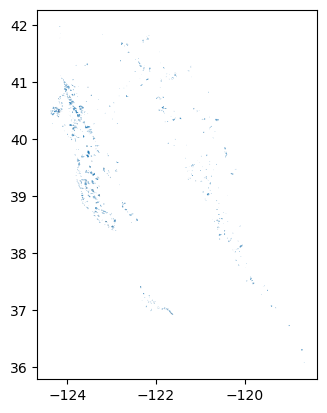

In [18]:
timber_management_data.plot()

In [19]:
# read in CA census tiger file
ca_tract_county = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_tract_county = gpd.read_file(ca_tract_county)
ca_tract_county = ca_tract_county.drop(columns={'field_1', 'geometry'})
ca_tract_county.columns = ca_tract_county.columns.str.lower()
ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)

In [20]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries = ca_boundaries[['GEOID', 'geometry']]
ca_boundaries = ca_boundaries.rename(columns={'GEOID':'tract'})

In [21]:
ca_tract_county_spatial = pd.merge(ca_tract_county, ca_boundaries, on='tract', how='left')
ca_tract_county_spatial

,tract,countyfp,county,geometry
0,06085504321,085,santa clara,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,085,santa clara,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,085,santa clara,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06085507004,085,santa clara,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,085,santa clara,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...
9124,06059001303,059,orange,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06059001304,059,orange,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06059001401,059,orange,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06013367200,013,contra costa,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


In [22]:
geo_ca_tract_county = gpd.GeoDataFrame(ca_tract_county_spatial)

In [23]:
# Step 1: Check the CRS
print("Initial CRS of NTMPs:", timber_management_data.crs)
print("Initial CRS of Counties:", geo_ca_tract_county.crs)

# Step 2: Reproject to an appropriate CRS for area calculations (e.g., EPSG:3310 for California)
gdf1 = timber_management_data.to_crs(epsg=3310)  # California Albers
gdf2 = geo_ca_tract_county.to_crs(epsg=3310)  # California Albers

print("Reprojected CRS of NTMPs:", gdf1.crs)
print("Reprojected CRS of Counties:", gdf2.crs)

# Step 3: Calculate the total area of NTMPs per county
ntmp_area_county = gdf1.dissolve(by='countyfp', aggfunc='sum')['geometry'].area.reset_index(name='NTMP_Area')

# Step 4: Calculate the total area of each county
county_area = gdf2.dissolve(by='countyfp', aggfunc='sum')['geometry'].area.reset_index(name='County_Area')

# Step 5: Merge the two datasets on the county column
merged_df = pd.merge(ntmp_area_county, county_area, on='countyfp')

# Step 6: Calculate the spatial percentage of NTMPs per county
merged_df['NTMP_Percentage'] = (merged_df['NTMP_Area'] / merged_df['County_Area']) * 100

# Display the resulting dataframe
print(merged_df)

Initial CRS of NTMPs: EPSG:4269
Initial CRS of Counties: EPSG:4269
Reprojected CRS of NTMPs: EPSG:3310
Reprojected CRS of Counties: EPSG:3310
   countyfp     NTMP_Area   County_Area  NTMP_Percentage
0       005  3.857830e+06  1.569404e+09         0.245815
1       007  1.127232e+07  4.343749e+09         0.259507
2       009  2.713285e+07  2.685627e+09         1.010299
3       015  1.458498e+06  3.184861e+09         0.045795
4       017  2.517660e+07  4.626653e+09         0.544164
5       019  8.704159e+06  1.556875e+10         0.055908
6       021  4.739893e+06  3.436854e+09         0.137914
7       023  4.885779e+08  1.049529e+10         4.655210
8       033  3.064982e+07  3.443201e+09         0.890155
9       035  2.464462e+07  1.222504e+10         0.201591
10      039  4.179547e+06  5.576864e+09         0.074944
11      043  1.899990e+07  3.788698e+09         0.501489
12      045  3.988460e+08  1.004437e+10         3.970840
13      049  3.056838e+06  1.088638e+10         0.028079
14 

In [24]:
timber_management_metric = pd.merge(ca_tract_county_spatial, merged_df, on='countyfp', how='left')
timber_management_metric

,tract,countyfp,county,geometry,NTMP_Area,County_Area,NTMP_Percentage
0,06085504321,085,santa clara,"POLYGON ((-121.87556 37.39924, -121.87535 37.3...",1.149785e+07,3.377489e+09,0.340426
1,06085504410,085,santa clara,"POLYGON ((-121.88886 37.40758, -121.88576 37.4...",1.149785e+07,3.377489e+09,0.340426
2,06085507003,085,santa clara,"POLYGON ((-122.02489 37.21683, -122.02459 37.2...",1.149785e+07,3.377489e+09,0.340426
3,06085507004,085,santa clara,"POLYGON ((-121.99304 37.22562, -121.99249 37.2...",1.149785e+07,3.377489e+09,0.340426
4,06085502204,085,santa clara,"POLYGON ((-121.93167 37.29803, -121.92801 37.3...",1.149785e+07,3.377489e+09,0.340426
...,...,...,...,...,...,...,...
9124,06059001303,059,orange,"POLYGON ((-117.95917 33.92458, -117.95888 33.9...",NaN,NaN,NaN
9125,06059001304,059,orange,"POLYGON ((-117.95918 33.92820, -117.95831 33.9...",NaN,NaN,NaN
9126,06059001401,059,orange,"POLYGON ((-117.95056 33.94503, -117.95055 33.9...",NaN,NaN,NaN
9127,06013367200,013,contra costa,"POLYGON ((-122.34551 37.96355, -122.34550 37.9...",NaN,NaN,NaN


In [25]:
eighty_five = timber_management_metric[timber_management_metric['countyfp'] == '045']
eighty_five

,tract,countyfp,county,geometry,NTMP_Area,County_Area,NTMP_Percentage
2918,06045010100,045,mendocino,"POLYGON ((-123.47510 39.92919, -123.47421 39.9...",3.988460e+08,1.004437e+10,3.97084
3792,06045010601,045,mendocino,"POLYGON ((-123.56907 39.34193, -123.56893 39.3...",3.988460e+08,1.004437e+10,3.97084
3794,06045011003,045,mendocino,"POLYGON ((-123.83048 39.36933, -123.83018 39.3...",3.988460e+08,1.004437e+10,3.97084
3795,06045011004,045,mendocino,"POLYGON ((-123.83183 39.35017, -123.83123 39.3...",3.988460e+08,1.004437e+10,3.97084
3797,06045010602,045,mendocino,"POLYGON ((-123.55247 39.42153, -123.55220 39.4...",3.988460e+08,1.004437e+10,3.97084
3798,06045011502,045,mendocino,"POLYGON ((-123.21138 39.17132, -123.21113 39.1...",3.988460e+08,1.004437e+10,3.97084
3799,06045011501,045,mendocino,"POLYGON ((-123.22712 39.16809, -123.22629 39.1...",3.988460e+08,1.004437e+10,3.97084
6420,06045010801,045,mendocino,"POLYGON ((-123.30628 39.33614, -123.30617 39.3...",3.988460e+08,1.004437e+10,3.97084
6421,06045010802,045,mendocino,"POLYGON ((-123.18672 39.39829, -123.18662 39.3...",3.988460e+08,1.004437e+10,3.97084
6425,06045011600,045,mendocino,"POLYGON ((-123.21293 39.15114, -123.21198 39.1...",3.988460e+08,1.004437e+10,3.97084


In [26]:
timber_management_metric.to_csv('governance_timber_management_metric.csv')

## Function Call

In [ ]:
@append_metadata
def timber_management_upload(input_csv, export=False, varname=''):
    '''
    Uploads the timber management metric to S3 bucket. The metric is:
    
    * % of county under timber management practices

    Data for this metric was sourced from the California Department of Forestry and Fire Protection (CalFire) at:
    https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::cal-fire-nonindustrial-timber-management-plans-ta83/about

    Note: data are for non-industrial timber management plans under 2,500 acres.

    Methods
    -------
    Relevant data columns were isolated, some were renamed for later merging with California tract data.
    
    
    Parameters
    ----------
    input_csv: string
        csv PSPS data 
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI timber management metric to AWS
        True = will upload resulting df containing CAL CRAI timber management metric to AWS

    Script
    ------
    governance_timber_management.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: relevant columns were isolated and renamed')
    print('Data transformation: duplicate entries by location were dropped.')
    print('Data transformation: number of rows per county were totalled.')
    print('Data transformation: data was merged with CA county and population data to generate final metric data.') 
 
    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{input_csv} uploaded to AWS.')
 
    if os.path.exists(input_csv):
        os.remove(input_csv)

In [ ]:
input_csv = 'governance_timber_management_metric.csv'
variable = 'governance_calfire_timber_management'
